Chen, Joy | May 2019 | Stat 418

# International Airfare Pricing and FX Arbitrage
# Data Cleaning and Exploratory Analysis Code

### Description
An analysis of international airfare prices from the U.S. to various destinations Europe. Data is collected via webscraping using BeautifulSoup. Data and analysis will be used to construct predictive linear model that will assist with airfare purchasing decisions.

### Acknowledgements
Courtesy of Norwegian Airlines

### Data Cleaning
Filtering for relevant rows / columns and creating new variable fields

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sb

import time
import datetime
import pytz
import re

# Set pandas view options
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 999)

In [20]:
# Load compiled data
tix_data = pd.read_csv('airfare_orig.csv')
tix_data.shape

(4847, 34)

In [21]:
# Convert date columns recognized date variables
tix_data['depart_date'] = pd.to_datetime(tix_data['depart_date'])
tix_data['data_extract_time'] = pd.to_datetime(tix_data['data_extract_time'], format = '%y-%m-%d %H:%M:%S')

In [22]:
# Sort data
tix_data.sort_values(['orig_port_code','dest_port_code', 'depart_date'], inplace = True)

In [23]:
# Drop any sold-out flights identified by id_leg1 = NaN
tix_data.dropna(subset=['id_leg1'], inplace = True)
# New dataframe dimensions
tix_data.shape

# Remove all prices expect for lowfare_USD (the class of airfare we will be predicting on)
tix_data = tix_data.iloc[:, :-19]

# Drop all rows with NaN lowfare_USD
tix_data.dropna(subset = ['prices_lowfare_USD'], inplace = True)

# New dimentions
tix_data.shape

(4413, 15)

In [24]:
# Separate data_extract_time into year, month, day components
tix_data.insert(5, 'depart_yr', tix_data['depart_date'].dt.year)
tix_data.insert(6, 'depart_mo', tix_data['depart_date'].dt.month)
tix_data.insert(7, 'depart_day', tix_data['depart_date'].dt.day)

# Calculate days to flight (as numeric)
tix_data.insert(5, 'days_to_flight', 
                (tix_data['depart_date'].dt.date-tix_data['data_extract_time'].dt.date).astype('timedelta64[D]'))

# Convert categorical airport codes to numeric dummies
tix_data.insert(5, 'orig_port_coded', list(pd.factorize(tix_data['orig_port_code'])[0]))
tix_data.insert(6, 'dest_port_coded', list(pd.factorize(tix_data['dest_port_code'])[0]))

# Convert some strange stops information, you can see how there are 2 that are unusual
list(tix_data.stops_loc.unique())
tix_data.stops_loc.replace(['This route has an overnight stop. Departure London 06:30', 'Stops: Oslo'], 
                           ['London', 'Oslo'], inplace = True)

In [25]:
tix_data.head(5)

,data_extract_time,id_leg1,orig_port_code,dest_port_code,depart_date,orig_port_coded,dest_port_coded,days_to_flight,depart_yr,depart_mo,depart_day,depart_time,arrive_time,duration_hrs,duration_min,duration_total_min,stops,id_leg2,stops_loc,stops_time,prices_lowfare_USD
247,2019-06-02 12:42:05,DI7016,JFK,ARN,2019-06-03,0,0,1.0,2019,6,3,23:00,16:30 +1,11,30,690,1,D82854,London,2h 10m,1172.9
248,2019-06-02 12:42:05,DI7018,JFK,ARN,2019-06-03,0,0,1.0,2019,6,3,22:00,16:30 +1,12,30,750,1,D82854,London,3h 10m,772.9
249,2019-06-02 12:42:05,DY7704,JFK,ARN,2019-06-03,0,0,1.0,2019,6,3,23:55,18:35 +1,12,40,760,1,D86092,Madrid,1h 40m,910.9
250,2019-06-02 12:42:05,DI7016,JFK,ARN,2019-06-03,0,0,1.0,2019,6,3,23:00,20:20 +1,15,20,920,1,D82856,London,6h 0m,1172.9
251,2019-06-02 12:42:05,DI7018,JFK,ARN,2019-06-03,0,0,1.0,2019,6,3,22:00,20:20 +1,16,20,980,1,D82856,London,7h 0m,772.9


In [11]:
# Filter for model variables of interest:
tix_data_model = tix_data.drop(['data_extract_time', 'id_leg1', 
                                'orig_port_code', 'dest_port_code',
                                'depart_date', 'depart_time', 'arrive_time', 
                                'duration_hrs', 'duration_min', 
                                'id_leg2', 'stops_loc', 'stops_time'],
                              axis = 1)
tix_data_model.shape

(4413, 9)

In [13]:
tix_data_model.head(5)

,orig_port_coded,dest_port_coded,days_to_flight,depart_yr,depart_mo,depart_day,duration_total_min,stops,prices_lowfare_USD
247,0,0,1.0,2019,6,3,690,1,1172.9
248,0,0,1.0,2019,6,3,750,1,772.9
249,0,0,1.0,2019,6,3,760,1,910.9
250,0,0,1.0,2019,6,3,920,1,1172.9
251,0,0,1.0,2019,6,3,980,1,772.9


In [9]:
# Export cleaned data
tix_data_model.to_csv('airfare_model.csv', index = False)

### Exploratory Analysis

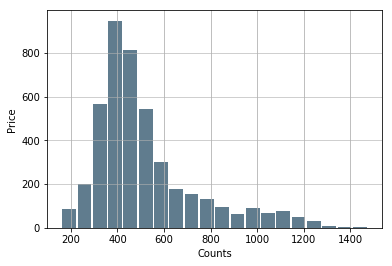

In [14]:
# Histogram of all prices
tix_data_model['prices_lowfare_USD'].plot.hist(grid=True, bins=20, rwidth=0.9,color='#607c8e')
plt.xlabel('Counts')
plt.ylabel('Price')
plt.grid(axis='y', alpha=0.75)

In [45]:
# Analyze where flights stop
print(tix_data.groupby('stops_loc').count().iloc[:,0])

# Total number of connecting flights
print(sum(tix_data.groupby('stops_loc').count().iloc[:,0]))
# Total direct
tix_data.stops_loc.isna().sum()

stops_loc
Amsterdam      129
Barcelona      239
Copenhagen     361
London        1109
Madrid         225
Oslo           840
Paris          101
Rome            64
Stockholm      532
Name: data_extract_time, dtype: int64
3600


813

Text(0,0.5,'Prices (USD) - Lowfare')

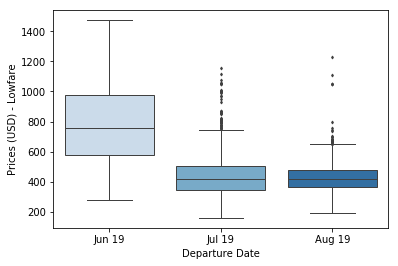

In [77]:
# Plot of prices vs. date
#tix_data[['prices_lowfare_USD','depart_date']].boxplot(by='depart_date',grid=False)

boxplot = sb.boxplot(x = tix_data['depart_date'].dt.strftime('%b %y'), 
                     y = tix_data['prices_lowfare_USD'],
                     linewidth = 1, fliersize = 2, 
                     palette = 'Blues')
plt.xlabel('Departure Date')
plt.ylabel('Prices (USD) - Lowfare')